# SeSiMe
### Sentence/Sequence Similarity Measure

### (2) Mass spec side
Import MS data and create documents.

Here: Use NOT Crusemann data, but other dataset where smilea are known for all spectra.

In [1]:
# data locations
# Windows 
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\SeSiMe\\data\\spectra_gnps\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"

In [8]:
# data locations
# Ubuntu VM
ROOT = "/media/sf_OneDrive-nlesc/Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "/SeSiMe/data/spectra_gnps/"
PATH_SAVE_DATA = ROOT + "/SeSiMe/data/"

In [2]:
import MS_functions

spectra, spectra_dict, MS_documents, MS_documents_intensity = MS_functions.load_MS_data(PATH_MS_DATA, PATH_SAVE_DATA,
                                        filefilter="*.ms",
                                         results_file = "MS_collected_data.json",
                                         num_decimals = 3,
                                         min_frag = 0.0, max_frag = 1200.0,
                                         min_loss = 10.0, max_loss = 500.0,
                                         min_intensity_perc = 0.0,
                                         exp_intensity_filter = 0.01,
                                         min_peaks = 10,
                                         merge_energies = True,
                                         merge_ppm = 5,
                                         replace = 'max')

Spectra json file found and loaded.


In [3]:
# Have a look at how a document looks like:
print(MS_documents[1])

['peak_146.937', 'peak_163.910', 'peak_171.848', 'peak_181.835', 'peak_182.754', 'peak_199.845', 'peak_200.778', 'peak_217.832', 'peak_223.989', 'peak_307.719', 'peak_313.898', 'peak_352.251', 'peak_370.019', 'peak_378.005', 'peak_387.998', 'peak_406.004', 'peak_420.102', 'peak_423.253', 'peak_423.917', 'loss_309.314', 'loss_292.341', 'loss_284.403', 'loss_274.416', 'loss_273.497', 'loss_256.407', 'loss_255.473', 'loss_238.419', 'loss_232.262', 'loss_148.532', 'loss_142.353', 'loss_104.000', 'loss_86.232', 'loss_78.246', 'loss_68.253', 'loss_50.247', 'loss_36.150', 'loss_32.998', 'loss_32.335']


#### Switch to general SeSiMe functionality
Once we have a corpus (e.g. through cells above), we can use SeSiMe to apply different similarity measuring methds. 

In [4]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

Using TensorFlow backend.


In [5]:
MS_measure.preprocess_documents(0.2, create_stopwords = False)

Preprocess documents...


### Word2Vec -based approach
Create Word2Vec based document centroid vectors.

Since spectra are built from manyn more possible words (much larger "dictionary"), vectors are reduced to 200 (instead of 100) dimensions.

In [6]:
file_model_word2vec = 'data\\model_word2vec_MS_ref_d200.model' 
MS_measure.build_model_word2vec(file_model_word2vec, size=200, window=50, 
                             min_count=1, workers=4, iter=250, 
                             use_stored_model=True)

Load stored word2vec model ...


In [7]:
MS_measure.get_vectors_centroid(weighted=True)
MS_measure.get_centroid_distances(num_hits=25, method='cosine')

  Calculated centroid vectors for  5770  of  5770  documents.

This has calculated (cosine) distances between all BGCs in an all-vs-all fashion.
The "num_hits" closest candidates for each BGC are listed in two matrices.

One stores the distances, the other the respective IDs.

In [14]:
MS_measure.Cdistances_ctr[1,:]

array([0.        , 0.33866781, 0.38053115, 0.38131775, 0.39100902,
       0.40501275, 0.41333177, 0.41938641, 0.42062295, 0.42464298,
       0.42514339, 0.43225172, 0.43933217, 0.44338653, 0.44664969,
       0.44789842, 0.44986025, 0.45374811, 0.45463476, 0.45790875,
       0.45999109, 0.46066714, 0.46180379, 0.46511136, 0.46740212])

In [15]:
MS_measure.Cdistances_ctr_idx[1,:]

array([   1, 5236, 5166, 5245,  979, 5232,  897, 5276, 5192, 5201, 5231,
       1650, 4592, 5258, 5229, 2916, 5274, 5235, 5208, 5157, 5288, 5256,
       5303, 5203, 5175])

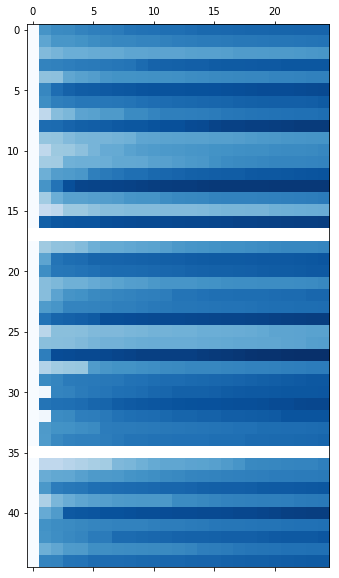

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(MS_measure.Cdistances_ctr[:45,:25], cmap=plt.cm.Blues)

### Plot molecules from smiles to visually compare selected spectra

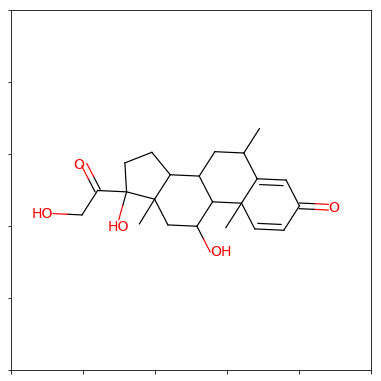

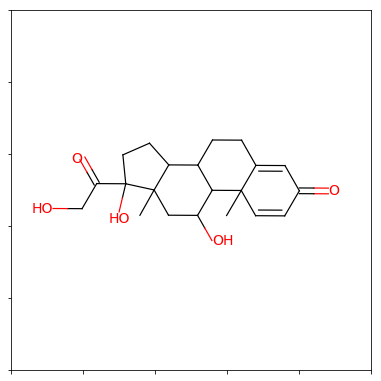

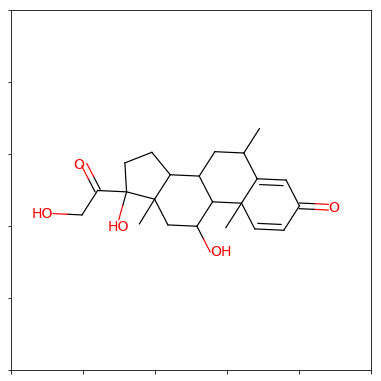

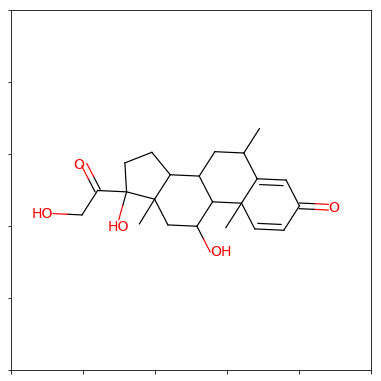

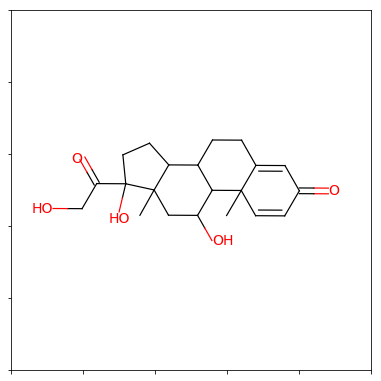

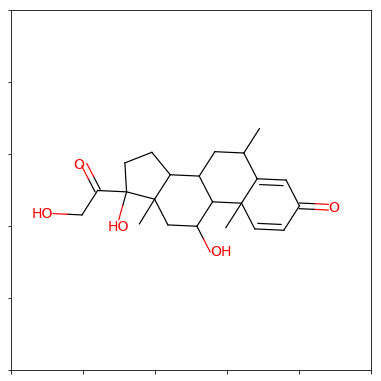

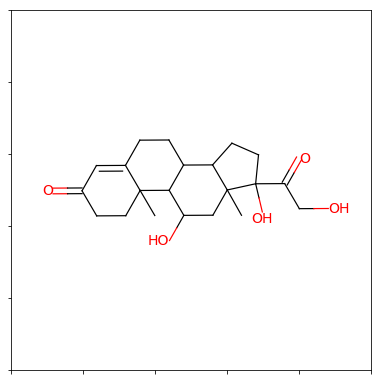

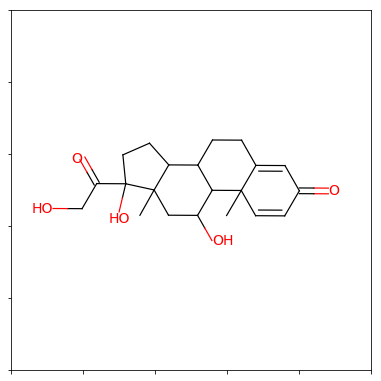

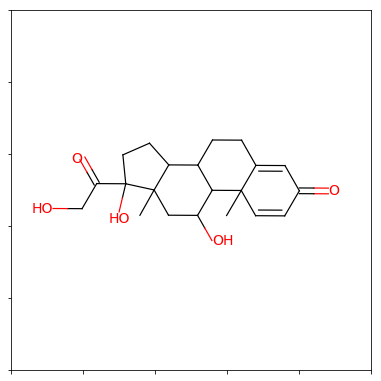

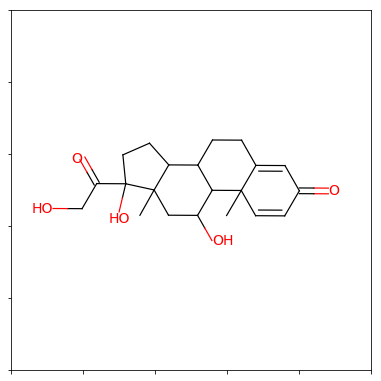

In [9]:
MS_functions.plot_smiles(85, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "centroid")

### Try different similarity measuring methods...

#### A) Autoencoder
Will train a deep autoencoder to generate 100 dimensional (or = encoding_dim) vectors representing each document. 

In [10]:
file_model_ae = 'data\\model_autoencoder_MS_ref.h5'
file_model_encoder = 'data\\model_encoder_MS_ref.h5'
MS_measure.build_autoencoder(file_model_ae, file_model_encoder, 
                             epochs = 10, batch_size = 1024, encoding_dim = 200,
                            layer_factors = (2,2,1))

No stored model found!
Creating new autoencoder model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               14287200  
_________________________________________________________________
dense_2 (Dense)              (None, 400)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_5 (Dense)              (None, 400)               80400     
_________________________________________________________________
dense_6 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_7 (Dense)    

In [11]:
MS_measure.get_autoencoder_distances(num_hits=25, method='cosine')

[0.00000000e+00 5.00042002e-08 5.45181902e-08 5.70141371e-08
 5.73981184e-08 5.94601914e-08 6.16103938e-08 6.17372152e-08
 6.28124363e-08 6.40211500e-08]


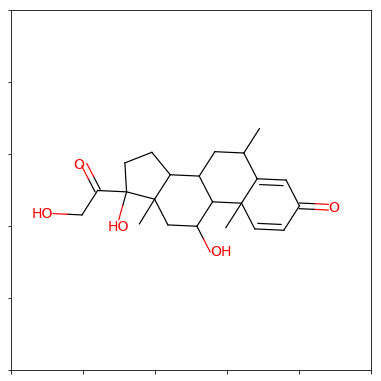

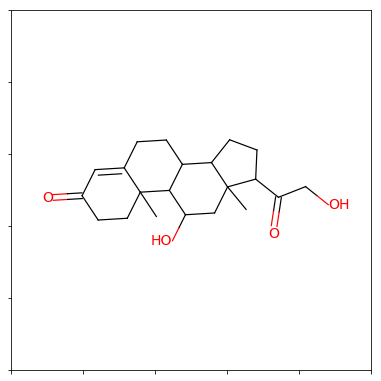

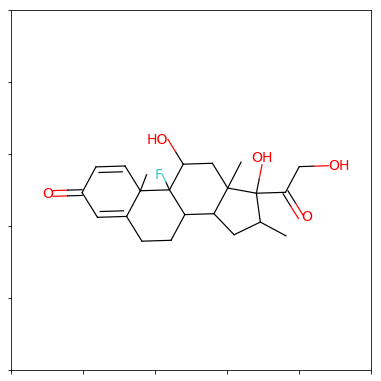

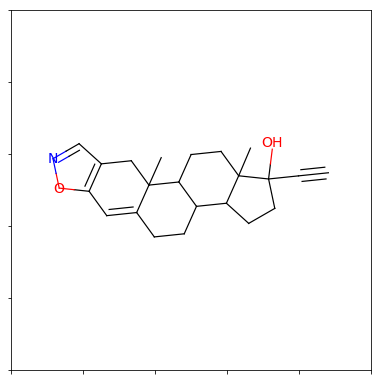

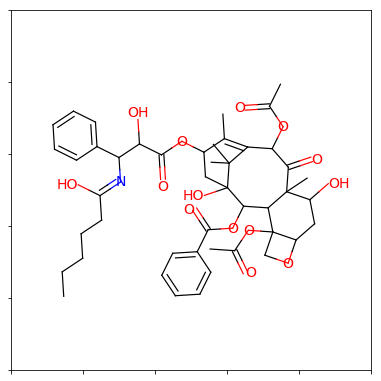

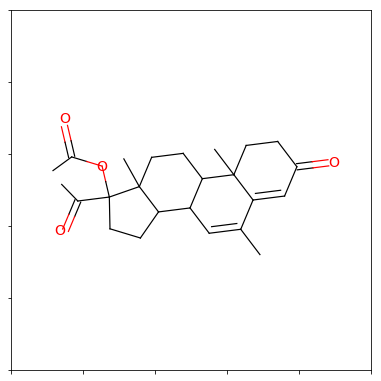

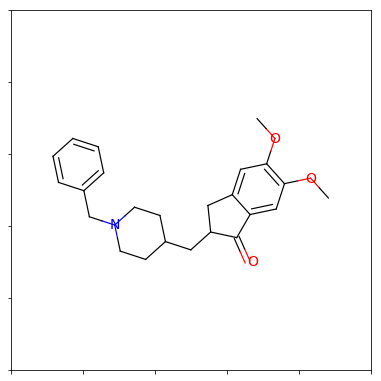

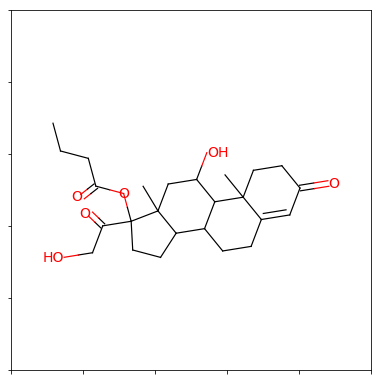

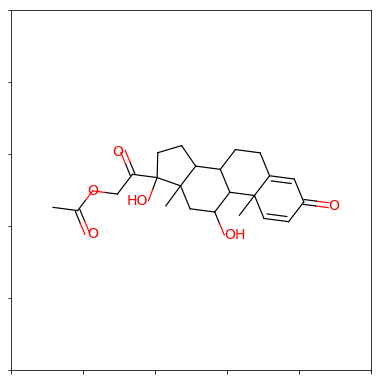

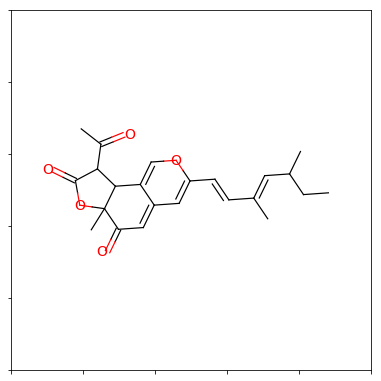

In [13]:
query_id = 85
print(MS_measure.Cdistances_ae[query_id, :10])
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "autoencoder")

#### B) PCA
Will calulate 200 dimensional representations of each document using PCA.

In [14]:
MS_measure.get_vectors_pca(200)

In [15]:
MS_measure.get_pca_distances(num_hits=25, method='cosine')

[0.         0.30405108 0.4850395  0.49591485 0.51674513 0.52593692
 0.56705579 0.60093781 0.6120955  0.63350553]


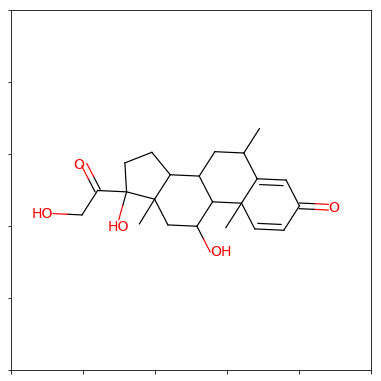

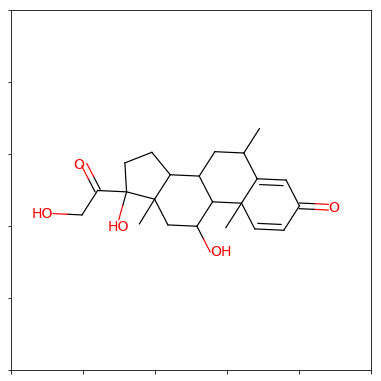

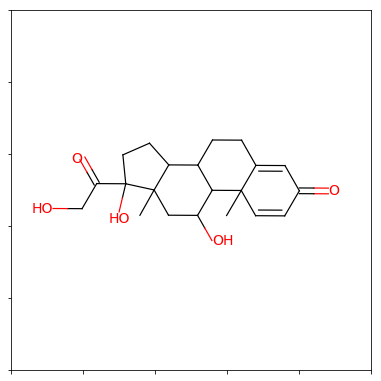

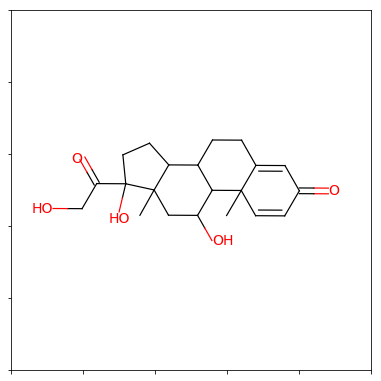

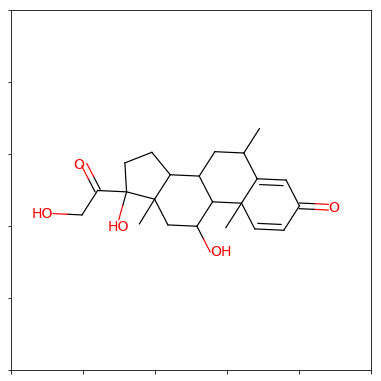

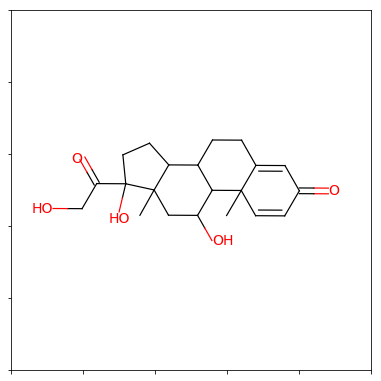

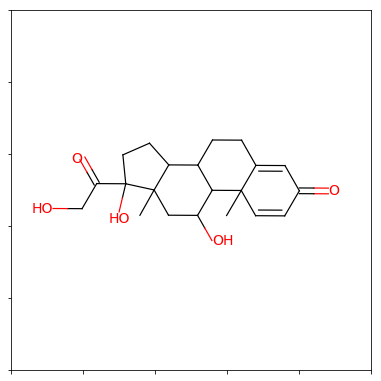

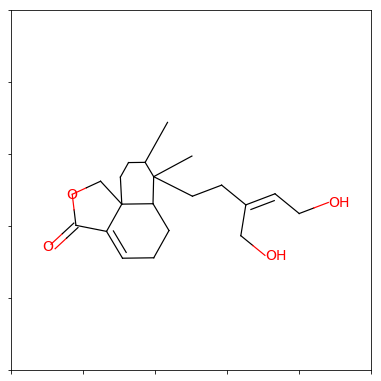

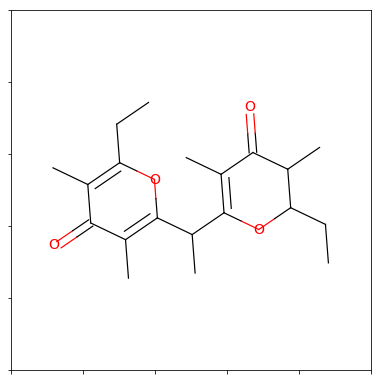

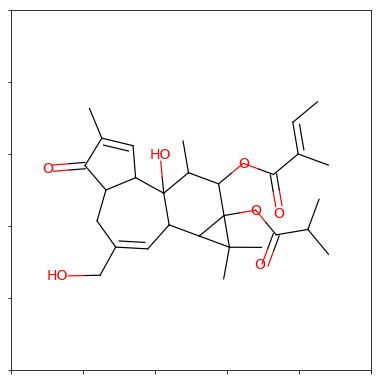

In [17]:
query_id = 85
print(MS_measure.Cdistances_pca[query_id, :10])
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "pca")

#### C) Doc2Vec
Will calulate 100 dimensional representations of each document using Doc2Vec.

In [18]:
file_model_doc2vec = "data\\model_doc2vec_MS_ref.model"
MS_measure.build_model_doc2vec(file_model_doc2vec, vector_size=200, window=50, 
                             min_count=1, workers=4, epochs=250, 
                             use_stored_model=True)

Stored doc2vec model not found!
Calculating new doc2vec model...


In [19]:
MS_measure.get_doc2vec_distances(num_hits=25, method='cosine')

[1.11022302e-16 1.88275285e-01 2.07867229e-01 2.09121450e-01
 2.18596212e-01 2.21561493e-01 2.22052251e-01 2.24888663e-01
 2.25114061e-01 2.27962206e-01]


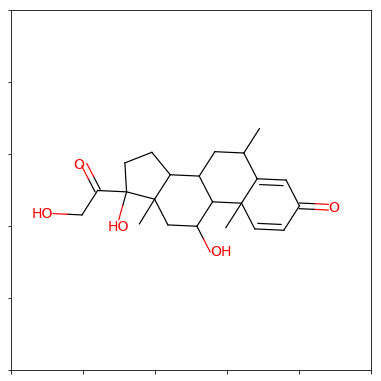

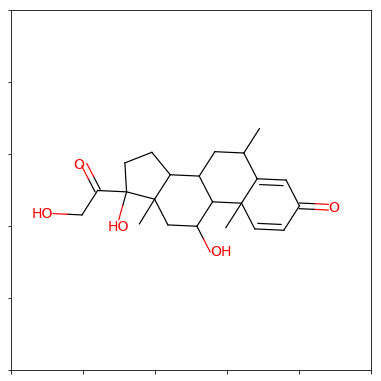

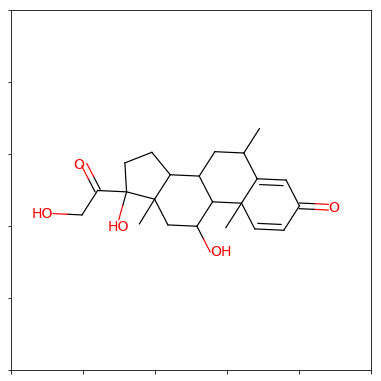

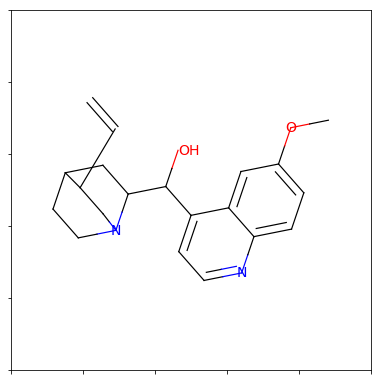

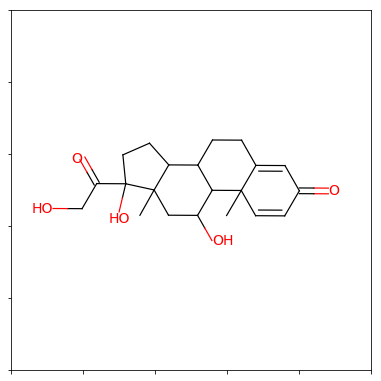

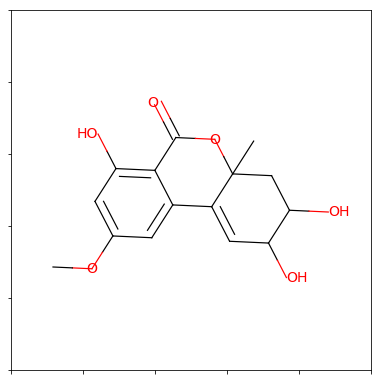

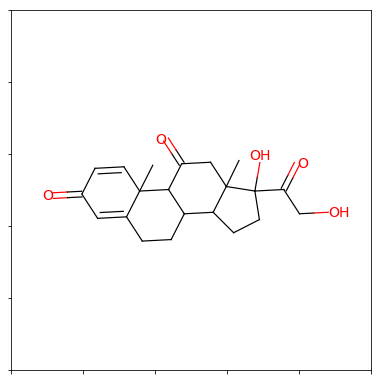

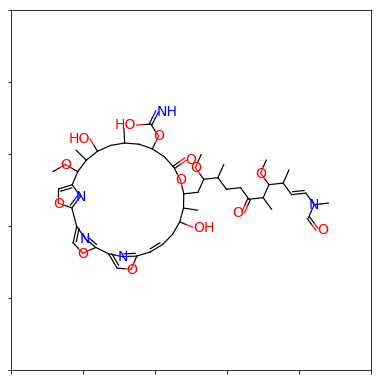

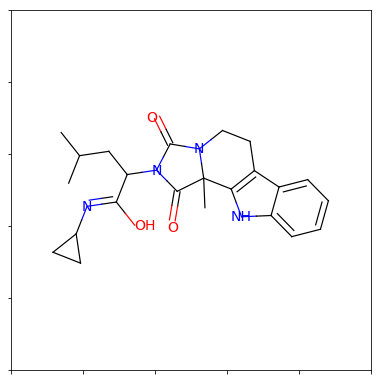

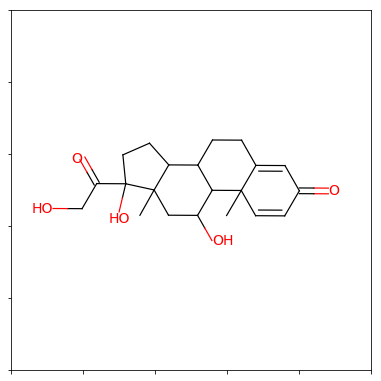

In [20]:
query_id = 85
print(MS_measure.Cdistances_d2v[query_id, :10])
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "doc2vec")

#### D) LDA
Will calulate document distances using LDA.

In [21]:
file_model_lda = "data\\model_lda_MS_ref.model"
MS_measure.build_model_lda(file_model_lda, num_of_topics=200, num_pass=4, 
                        num_iter=100, use_stored_model=True)

Stored LDA model not found!
Calculating new LDA model...


C:\Users\FlorianHuber\Anaconda3\envs\SeSiMe-env\lib\site-packages\gensim\models\ldamodel.py:1030: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


'Keyword in the 10 topics'
[(126,
  '0.032*"loss_45.021" + 0.013*"peak_196.076" + 0.011*"loss_30.010" + '
  '0.011*"peak_253.195" + 0.009*"peak_183.092" + 0.008*"loss_58.030" + '
  '0.008*"peak_157.084" + 0.008*"peak_236.071" + 0.008*"peak_156.081" + '
  '0.007*"peak_125.017"'),
 (117,
  '0.014*"peak_93.034" + 0.011*"peak_184.084" + 0.011*"peak_186.066" + '
  '0.009*"peak_108.046" + 0.009*"loss_161.082" + 0.009*"peak_152.069" + '
  '0.009*"loss_72.056" + 0.007*"peak_201.053" + 0.007*"peak_169.067" + '
  '0.007*"peak_221.088"'),
 (175,
  '0.011*"loss_131.040" + 0.011*"peak_148.062" + 0.011*"peak_104.056" + '
  '0.011*"peak_147.065" + 0.011*"loss_189.173" + 0.011*"loss_164.131" + '
  '0.010*"peak_93.071" + 0.010*"peak_120.079" + 0.009*"loss_122.096" + '
  '0.009*"loss_207.127"'),
 (4,
  '0.008*"peak_274.107" + 0.007*"peak_103.055" + 0.007*"peak_104.059" + '
  '0.007*"peak_135.041" + 0.007*"loss_290.127" + 0.006*"peak_219.100" + '
  '0.006*"loss_164.080" + 0.006*"peak_254.091" + 0.005*"lo

In [22]:
MS_measure.get_lda_distances(num_hits=25)

[0.         0.07840133 0.07840133 0.07840133 0.07840133 0.07888448
 0.07917434 0.08557528 0.16380405 0.17856294]


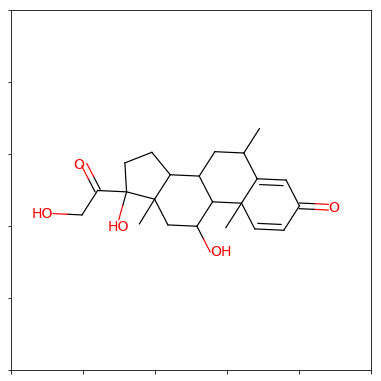

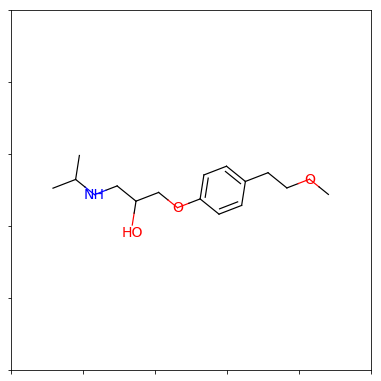

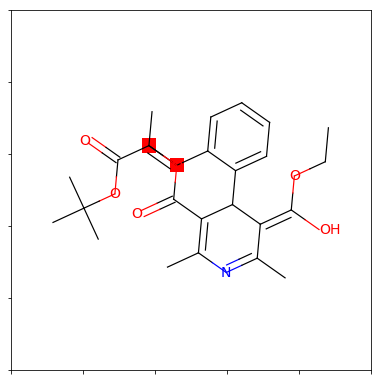

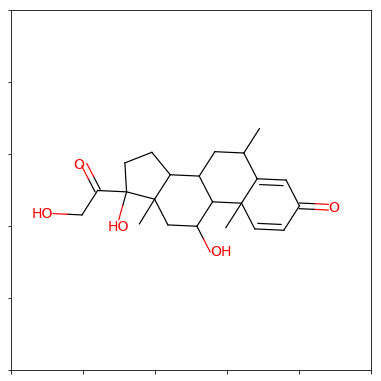

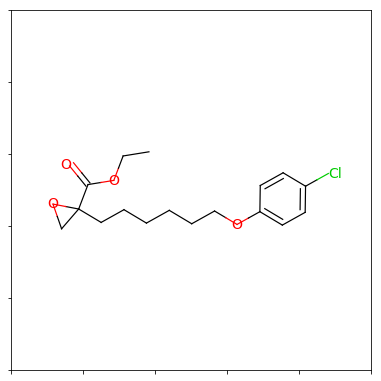

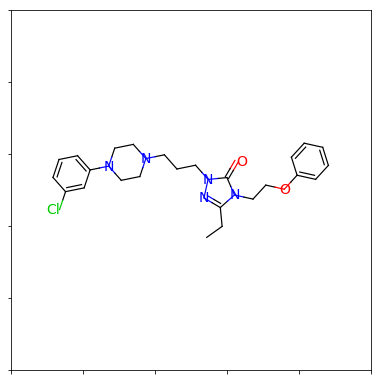

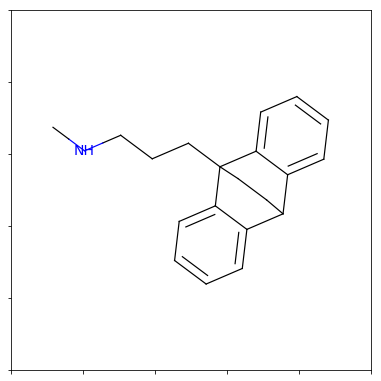

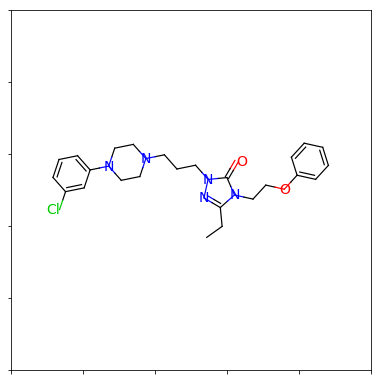

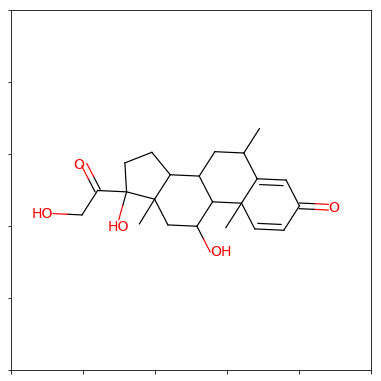

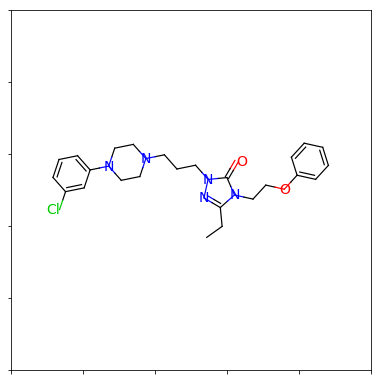

In [23]:
query_id = 85
print(MS_measure.Cdistances_lda[query_id, :10])
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "lda")

#### E) LSI
Will calulate document distances using LSI.

In [24]:
file_model_lsi = "data\\model_lsi_MS_ref.model"
MS_measure.build_model_lsi(file_model_lsi, num_of_topics=200, 
                             use_stored_model=True)

Stored LSI model not found!
Calculating new LSI model...


In [25]:
MS_measure.get_lsi_distances(num_hits=25)

[0.         0.07875121 0.07875121 0.07875121 0.07875121 0.07923418
 0.0795384  0.08596176 0.16356981 0.178873  ]


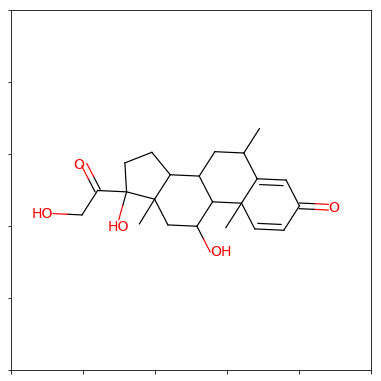

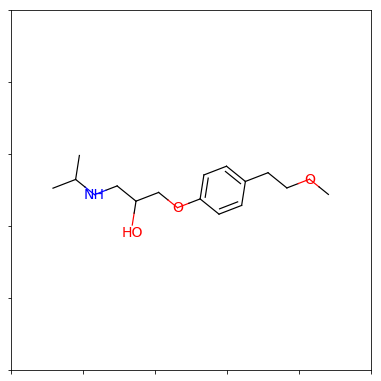

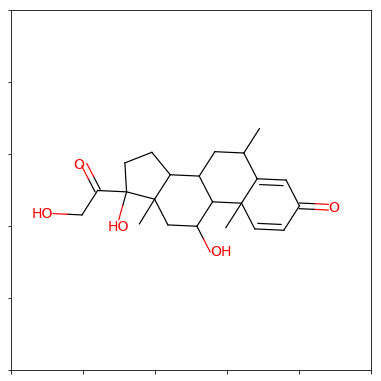

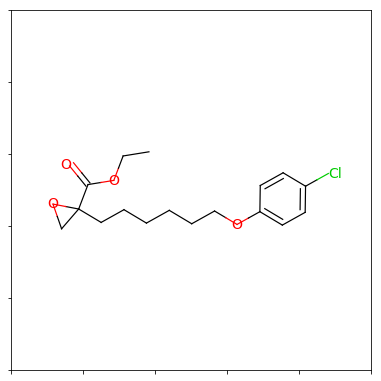

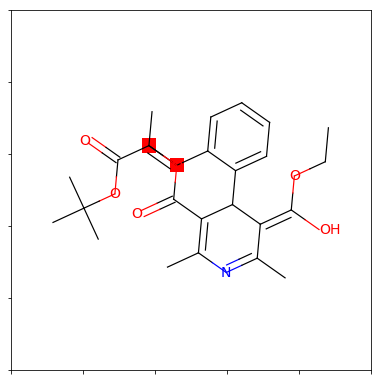

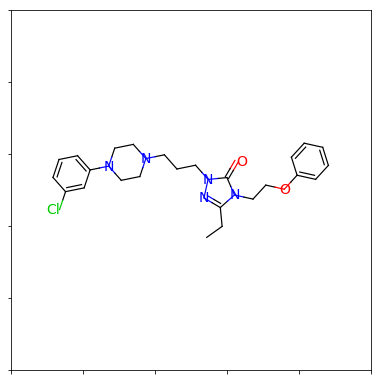

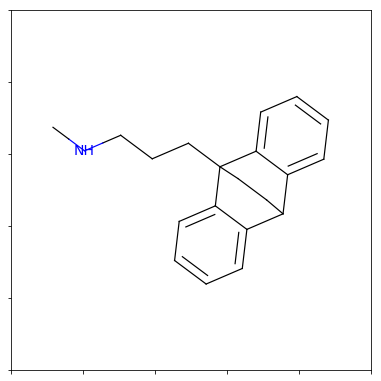

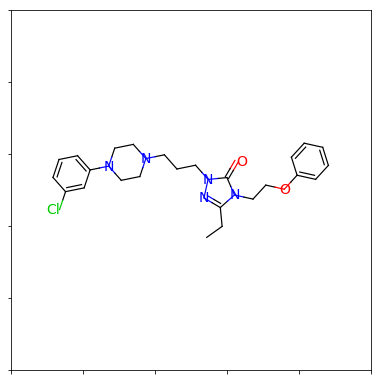

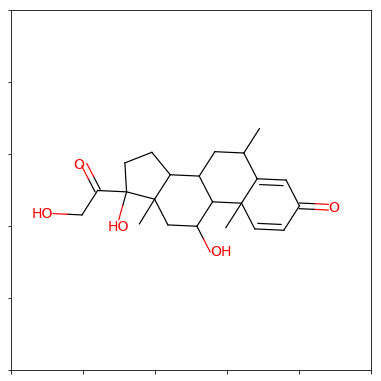

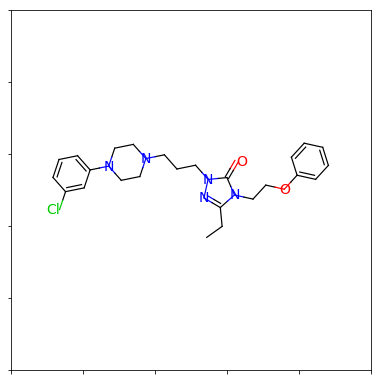

In [26]:
query_id = 85
print(MS_measure.Cdistances_lsi[query_id, :10])
MS_functions.plot_smiles(query_id, spectra_dict, MS_measure, num_candidates = 10, 
                   sharex=True, labels=False, dist_method = "lsi")